In [2]:
# =============================================================
# DSRN for Drosophila Gene Expression Prediction (with coords)
# Predict next timepoint from previous timepoint; include (x,y,z)
# =============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
import seaborn as sns
import os, json

# -----------------------------
# Config / Files
# -----------------------------
file = "valid_genes_filtered.csv"   # ensure this is present
assert os.path.exists(file), f"File not found: {file}"

# reservoir / solver params (tweakable)
N = 150                 # number of reservoirs
t_initial, t_final = 0, 4
num_eval_points = 200
np.random.seed(42)

# -----------------------------
# Load table
# -----------------------------
df = pd.read_csv(file, header=None)   # your file had no header
print("Loaded data shape:", df.shape)

# Data layout assumptions (per earlier messages):
# - row 0: name row (NaN in col0, then cell labels)
# - row 1: x_coord
# - row 2: y_coord
# - row 3: z_coord
# - rows 4.. end: gene rows in blocks of 6 (gene_t1, gene_t2, ..., gene_t6)
#   Each such row: [gene_name_t?, val_cell1, val_cell2, ..., val_cellN]
# We'll take columns 1: because column 0 contains gene names/labels.

# -----------------------------
# Extract coords and expressions
# -----------------------------
coords_rows = df.iloc[2:5, 1:].astype(float).values    # shape (3, num_cells) -> x,y,z
expr_rows   = df.iloc[5:, 1:].astype(float).values    # shape (6*num_genes, num_cells)

num_cells = expr_rows.shape[1]
num_gene_rows = expr_rows.shape[0]          # should be 6 * num_genes
assert num_gene_rows % 6 == 0, "Expected gene rows to be multiple of 6"
num_genes = num_gene_rows // 6

print(f"Cells (samples) = {num_cells}, Genes = {num_genes} (6 timepoints each)")

# -----------------------------
# Build X and Y: transitions t->t+1 across genes
# For each gene block (6 rows), we build 5 transitions:
#   X = row t  (values across all cells)  -> shape (num_features, num_cells)
#   Y = row t+1
# Note: We'll later add coords (3 rows) as extra input features.
# -----------------------------
X_list = []
Y_list = []

for g in range(num_genes):
    block = expr_rows[g*6:(g+1)*6, :]   # shape (6, num_cells)
    for t in range(5):                  # transitions: 0->1,1->2,...,4->5
        X_list.append(block[t, :].copy())    # shape (num_cells,)
        Y_list.append(block[t+1, :].copy())

# stack into arrays
X = np.vstack(X_list)   # shape (5*num_genes, num_cells)
Y = np.vstack(Y_list)   # same shape

print("Raw X shape (transitions x cells):", X.shape)
print("Raw Y shape (transitions x cells):", Y.shape)

# -----------------------------
# Add coordinates as additional constant features
# coords_rows shape = (3, num_cells)
# We want to prepend these 3 rows so the input feature dimension increases by 3.
# After this: X_with_coords shape = (5*num_genes + 3, num_cells)
# -----------------------------
X_with_coords = np.vstack([coords_rows, X])   # coords first, then gene-transition rows
print("X_with_coords shape (features x cells):", X_with_coords.shape)

# You may want to scale coords differently (e.g., standardize) — we'll standardize globally below.

# -----------------------------
# Train/test split across cells (samples)
# 80% cells train, 20% test — i.e., columns are samples
# -----------------------------
cells = np.arange(num_cells)
train_cells, test_cells = train_test_split(cells, test_size=0.2, random_state=42)
print("Train cells:", len(train_cells), "Test cells:", len(test_cells))

# -----------------------------
# Normalize (global scalers)
# We'll fit scalers on all training cells (columns) for inputs & outputs.
# Our scalers must operate on (samples x features) when using sklearn — so we transpose.
# - input scaler fits on X_with_coords.T shape (num_cells, num_features)
# - output scaler fits on Y.T shape (num_cells, num_output_features)
# After transform we transpose back to keep shape (features, cells)
# -----------------------------
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

# Fit using only train cells to avoid leakage
scaler_X.fit(X_with_coords[:, train_cells].T)   # shape (n_train_cells, n_features)
scaler_Y.fit(Y[:, train_cells].T)

X_norm = scaler_X.transform(X_with_coords.T).T   # (features, cells)
Y_norm = scaler_Y.transform(Y.T).T               # (features, cells)  (features == transitions)

print("X_norm shape:", X_norm.shape, "Y_norm shape:", Y_norm.shape)

# Dimensions used by reservoir code:
M = X_norm.shape[0]   # input dimension (features) -> now includes 3 coords + 5*num_genes
D = X_norm.shape[1]   # number of samples (cells)
P = Y_norm.shape[0]   # output dim (number of transitions = 5*num_genes)
print("M (input features) =", M, "D (cells) =", D, "P (output dim) =", P)

# -----------------------------
# Reservoir setup
# -----------------------------
# reservoir_params: for each of N reservoirs: (sigma, rho, beta, T)
param_range_reservoir = [(9.9, 10.1), (27.9, 28.1), (2.65, 2.70)]
reservoir_params = np.array([
    [np.random.uniform(low, high) for (low, high) in param_range_reservoir] + [np.random.uniform(1, 8)]
    for _ in range(N)
])  # shape (N, 4)

# Input matrix R: shape (3*N, M) to map M-dim input vector into 3N initial conditions
R = np.random.uniform(-1.0, 1.0, size=(3 * N, M))
print("reservoir_params shape:", reservoir_params.shape, "R shape:", R.shape)

# -----------------------------
# Lorenz / Rossler-like reservoir function (Lorenz here)
# -----------------------------
def lorenz_system(t, Xvec, params):
    # Xvec length = 3*N -> reshape to (N, 3)
    X = Xvec.reshape(N, 3)
    sigma = params[:, 0]
    rho   = params[:, 1]
    beta  = params[:, 2]
    T_val = params[:, 3]   # timescale
    dx = (sigma * (X[:, 1] - X[:, 0])) / T_val
    dy = (X[:, 0] * (rho - X[:, 2]) - X[:, 1]) / T_val
    dz = (X[:, 0] * X[:, 1] - beta * X[:, 2]) / T_val
    return np.stack([dx, dy, dz], axis=1).flatten()

# -----------------------------
# Compute reservoir states φ for each cell (sample)
# φ has shape (3*N, D)
# For each cell i: initial cond = R @ X_norm[:, i]   (length 3N)
# integrate to t_final, take final state sol.y[:,-1]
# -----------------------------
phi = np.zeros((3 * N, D))
for i in range(D):
    init = (R @ X_norm[:, i]).flatten()
    sol = solve_ivp(lorenz_system, (t_initial, t_final), init, t_eval=[t_final],
                    args=(reservoir_params,), rtol=1e-6, atol=1e-9)
    phi[:, i] = sol.y[:, -1]

print("phi shape (3N x D):", phi.shape)

# -----------------------------
# Prepare training matrices for readout learning
# Note: we use only train_cells columns for training
# phi_train: (n_train_samples, features) for lstsq we need as (samples, features)
# Y_train:    (n_train_samples, P_out) float
# -----------------------------
phi_train = phi[:, train_cells].T    # shape (n_train, 3N)
phi_test  = phi[:, test_cells].T     # shape (n_test , 3N)

Y_train = Y_norm[:, train_cells].T   # shape (n_train, P)
Y_test  = Y_norm[:, test_cells].T    # shape (n_test, P)

print("phi_train:", phi_train.shape, "Y_train:", Y_train.shape)

# -----------------------------
# Solve for S (readout) with least squares (no ridge)
# We solve phi_train @ S_T = Y_train  -> S_T = np.linalg.lstsq(phi_train, Y_train)
# S_T shape (3N, P), so S = S_T.T will be (P, 3N)
# -----------------------------
S_T, residuals, rank, svals = np.linalg.lstsq(phi_train, Y_train, rcond=None)
S = S_T.T
print("S shape (P x 3N):", S.shape)

# -----------------------------
# Predict (on normalized scale)
# pred_norm = S @ phi[:, idx]  -> gives shape (P, n_cells)
# -----------------------------
pred_train_norm = S @ phi[:, train_cells]   # (P, n_train)
pred_test_norm  = S @ phi[:, test_cells]    # (P, n_test)

# inverse-transform predictions to original output scale using scaler_Y
# scaler_Y expects shape (n_samples, n_features) = (n_train, P) so transpose
pred_train = scaler_Y.inverse_transform(pred_train_norm.T).T   # (P, n_train)
pred_test  = scaler_Y.inverse_transform(pred_test_norm.T).T    # (P, n_test)

# Ground-truth (original Y)
Y_train_true = Y[:, train_cells].astype(float)   # (P, n_train)
Y_test_true  = Y[:, test_cells].astype(float)    # (P, n_test)

# Ensure float arrays
pred_train = pred_train.astype(float)
pred_test  = pred_test.astype(float)

# -----------------------------
# Metrics
# -----------------------------
mse_train = np.mean((pred_train - Y_train_true) ** 2)
mse_test  = np.mean((pred_test  - Y_test_true) ** 2)
r_train, p_train = pearsonr(pred_train.flatten(), Y_train_true.flatten())
r_test,  p_test  = pearsonr(pred_test.flatten(),  Y_test_true.flatten())

print("\n=== Summary metrics ===")
print(f"Train MSE = {mse_train:.6e}, Test MSE = {mse_test:.6e}")
print(f"Train Pearson r = {r_train:.4f} (p={p_train:.2e})")
print(f"Test  Pearson r = {r_test:.4f} (p={p_test:.2e})")


/var/folders/rp/3svz678x3dlfx98xp15q82b12rg7gw/T/ipykernel_89484/4077973572.py:31: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,25

Loaded data shape: (167, 6079)
Cells (samples) = 6078, Genes = 27 (6 timepoints each)
Raw X shape (transitions x cells): (135, 6078)
Raw Y shape (transitions x cells): (135, 6078)
X_with_coords shape (features x cells): (138, 6078)
Train cells: 4862 Test cells: 1216
X_norm shape: (138, 6078) Y_norm shape: (135, 6078)
M (input features) = 138 D (cells) = 6078 P (output dim) = 135
reservoir_params shape: (150, 4) R shape: (450, 138)
phi shape (3N x D): (450, 6078)
phi_train: (4862, 450) Y_train: (4862, 135)
S shape (P x 3N): (135, 450)

=== Summary metrics ===
Train MSE = 3.028979e-03, Test MSE = 3.750720e-03
Train Pearson r = 0.9677 (p=0.00e+00)
Test  Pearson r = 0.9603 (p=0.00e+00)


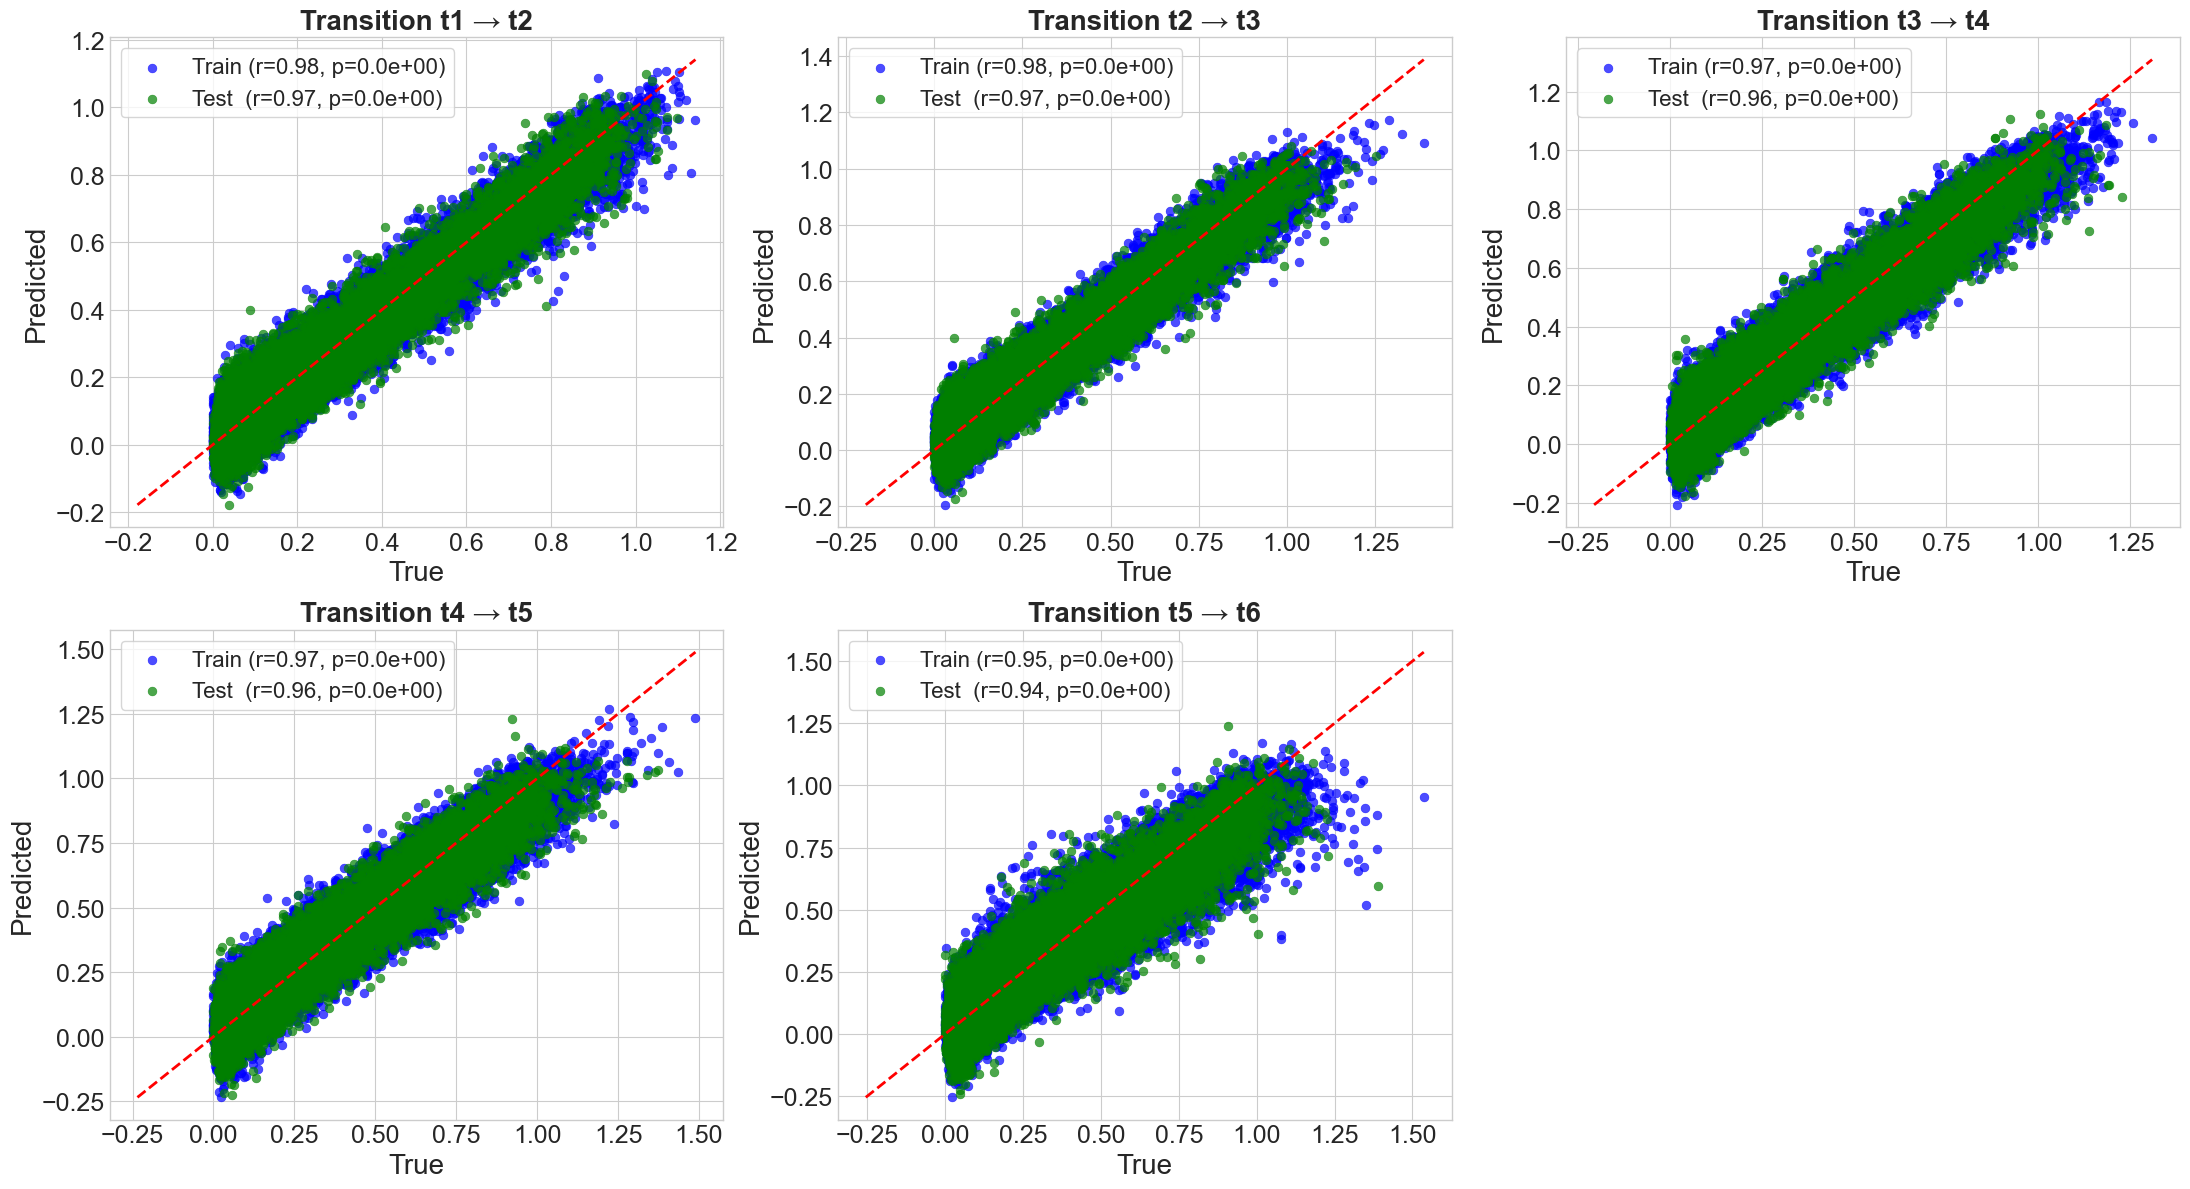

In [3]:
# -----------------------------
# Plot scatter per transition (t -> t+1)
# We'll treat transitions ordered as in X/Y stacking:
# transitions = 0..(5*num_genes-1)
# We want to show a grid of 5 subplots (t1->t2, ... t5->t6).
# For each transition, scatter True vs Pred for train (blue) and test (green)
# and show r and p values separately computed for that transition.
# -----------------------------
num_transitions = 5 * num_genes
num_timepoints = 5  # transitions per gene

plt.style.use("seaborn-v0_8-whitegrid")  # cleaner background

fig, axes = plt.subplots(2, 3, figsize=(22, 12))
axes = axes.flatten()

for t in range(num_timepoints):
    ax = axes[t]

    # indices in P-space: t, t+5, t+10, ..., t + 5*(num_genes-1)
    idxs = np.arange(t, num_transitions, num_timepoints)

    true_train_t = Y_train_true[idxs, :].flatten()
    pred_train_t = pred_train[idxs, :].flatten()
    true_test_t  = Y_test_true[idxs, :].flatten()
    pred_test_t  = pred_test[idxs, :].flatten()

    r_tr, p_tr = pearsonr(true_train_t, pred_train_t)
    r_te, p_te = pearsonr(true_test_t, pred_test_t)

    # bigger clearer scatter points
    ax.scatter(true_train_t, pred_train_t, s=40, alpha=0.7,
               label=f"Train (r={r_tr:.2f}, p={p_tr:.1e})",
               color='blue', linewidth=0.4)

    ax.scatter(true_test_t, pred_test_t, s=40, alpha=0.7,
               label=f"Test  (r={r_te:.2f}, p={p_te:.1e})",
               color='green', linewidth=0.4)

    # diagonal line
    mn = min(true_train_t.min(), true_test_t.min(),
             pred_train_t.min(), pred_test_t.min())
    mx = max(true_train_t.max(), true_test_t.max(),
             pred_train_t.max(), pred_test_t.max())

    ax.plot([mn, mx], [mn, mx], 'r--', linewidth=2)

    # big labels and ticks
    ax.set_title(f"Transition t{t+1} → t{t+2}", fontsize=20, fontweight='bold')
    ax.set_xlabel("True", fontsize=20)
    ax.set_ylabel("Predicted", fontsize=20)
    ax.tick_params(axis='both', labelsize=18)
    ax.grid(True, linewidth=0.8)

    ax.legend(fontsize=16, frameon=True)

# hide last empty subplot
for k in range(num_timepoints, len(axes)):
    axes[k].axis('off')

plt.tight_layout()

# -----------------------------
# Save high-quality PNG @300 dpi
# -----------------------------
plt.savefig("drosophila_transition_scatter.jpeg", format = 'jpeg', dpi=650, bbox_inches="tight")

plt.show()
